In [ ]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import py4DSTEM
import pyprismatic
from pyprismatic.process import get_pixel_size, get_tilts, rad_gaussian

## Simulation

In [ ]:
#output paths
tilt_hrtem_folder = "outputs/hrtem_tilt_coherence/"

#input paths
fp_atoms = "structure_files/monolayer_WS2.xyz"

In [ ]:
dfs = [26.0, 98.0, 314.0, 569.0]

In [4]:
tilt_hrtem_meta = pyprismatic.Metadata()
tilt_hrtem_meta.E0 = 300
tilt_hrtem_meta.filenameAtoms = fp_atoms
tilt_hrtem_meta.realspacePixelSize = 0.075
tilt_hrtem_meta.potential3D = False
tilt_hrtem_meta.includeThermalEffects = False
tilt_hrtem_meta.algorithm = "hrtem"

In [ ]:
tilt_hrtem_meta.minRtilt = 0.0
tilt_hrtem_meta.maxRtilt = 3.0
tilt_hrtem_meta.interpolationFactorX = 6
tilt_hrtem_meta.interpolationFactorY = 4

if not pathlib.Path(tilt_hrtem_folder+"tilt_hrtem_sigma_1_df_%i" % int(dfs[-1]) + ".h5").exists():
    for df in dfs:
        tilt_hrtem_meta.probeDefocus = df
        tilt_hrtem_fp = tilt_hrtem_folder+"tilt_hrtem_sigma_1_df_%i" % int(df) + ".h5"
        tilt_hrtem_meta.filenameOutput = tilt_hrtem_fp
        tilt_hrtem_meta.go()

In [ ]:
tilt_hrtem_meta.minRtilt = 0.0
tilt_hrtem_meta.maxRtilt = 15.0
tilt_hrtem_meta.interpolationFactorX = 24
tilt_hrtem_meta.interpolationFactorY = 16

if not pathlib.Path(tilt_hrtem_folder+"tilt_hrtem_sigma_5_df_%i" % int(dfs[-1]) + ".h5").exists():
    for df in dfs:
        tilt_hrtem_meta.probeDefocus = df
        tilt_hrtem_fp = tilt_hrtem_folder+"tilt_hrtem_sigma_5_df_%i" % int(df) + ".h5"
        tilt_hrtem_meta.filenameOutput = tilt_hrtem_fp
        tilt_hrtem_meta.go()

## Plotting

In [ ]:
def get_mask(dc):
    mask = np.logical_not(np.isnan(dc.data[0,0,:,:]))
    
    return mask

def get_weights(sigma, rt, mask):
    tilt_weights = rad_gaussian(sigma=sigma, r=rt)
    tilt_weights *= mask
    tilt_weights /= np.sum(tilt_weights) #normalize to sum to 1
    return tilt_weights

def get_rt(tilt_x, tilt_y):
    xt, yt = np.meshgrid(tilt_x, tilt_y)
    rt = np.sqrt(xt**2.0 + yt**2.0)
    return rt

In [ ]:
os.listdir(tilt_hrtem_folder)
files = [f for f in os.listdir(tilt_hrtem_folder) if (("sigma_1" in f) or ("sigma_5" in f)) and int(f.split("_")[-1][:-3]) in [26, 98, 314, 569]]
files.sort(key= lambda x: int(x.split("_")[-1][:-3]))
dfs = [int(x.split("_")[-1][:-3]) for x in files]

In [ ]:
dcs = []
for f in files:
    print("on ", f)
    tilt_hrtem_fp = tilt_hrtem_folder+f
    dc = py4DSTEM.io.read(tilt_hrtem_fp, data_id="HRTEM_virtual")
    dcs.append(dc)

In [ ]:
px, py = get_pixel_size(tilt_hrtem_folder+files[0])

In [ ]:
tilt_x_1, tilt_y_1 = get_tilts(tilt_hrtem_folder+files[0])
tilt_x_5, tilt_y_5 = get_tilts(tilt_hrtem_folder+files[1])

In [ ]:
rt_1 = get_rt(tilt_y_1, tilt_x_1)
rt_5 = get_rt(tilt_y_5, tilt_x_5)

In [ ]:
all_baselines = []
for sigma in [0.3, 1.0]:
    baselines = []
    weights = get_weights(sigma, rt_1, base_mask_1)
    for i, dc in enumerate(dcs):
        if(not (i % 2)):
            baseline = np.nansum(dc.data*weights, axis=(2,3))
            baselines.append(baseline)
    all_baselines.append(baselines)
    
for sigma in [5.0]:
    baselines = []
    weights = get_weights(sigma, rt_5, base_mask_5)
    for i, dc in enumerate(dcs):
        if((i % 2)):
            baseline = np.nansum(dc.data*weights, axis=(2,3))
            baselines.append(baseline)
    all_baselines.append(baselines)

In [ ]:
centers = []
for i, dc in enumerate(dcs):
    if(i % 2):
        centers.append(dc.data[:,:,10,8])
    else:
        centers.append(dc.data[:,:,8,6])

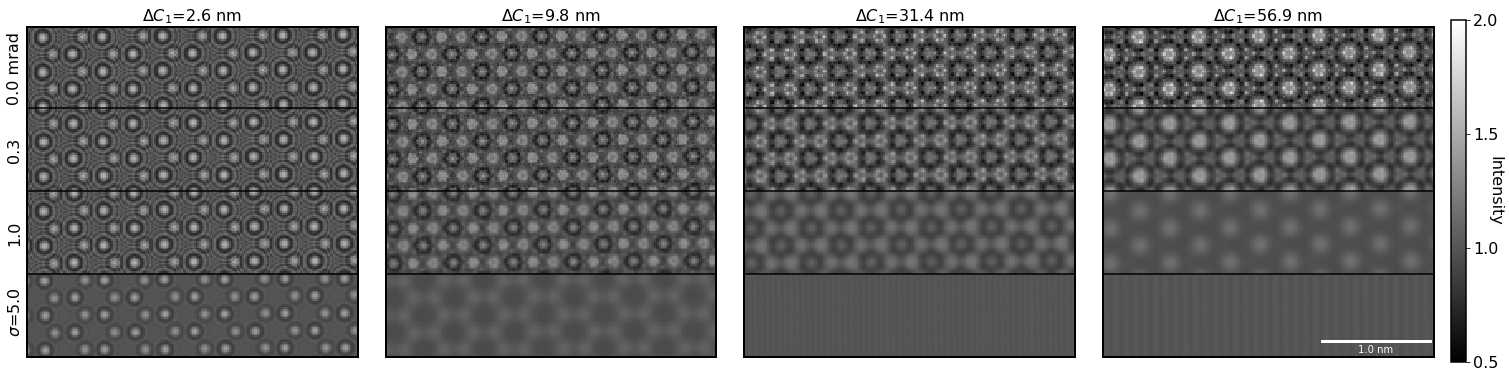

In [44]:
f = plt.figure(constrained_layout=True, figsize=(20,5))

gs = f.add_gridspec(1,4)
axes = []
for i in range(4):
    f_im = f.add_subplot(gs[i])
    axes.append(f_im)
        
si = 400
ei = 600

vmin = 0.5
vmax = 2.0

keep_idx = [0,1,2,3]
imgs = np.zeros((ei-si, ei-si, 4))
for i in range(4):
    imgs[0:50,:,i] = centers[2*i][si:si+50, si:ei]
    imgs[50:100,:,i] = all_baselines[0][keep_idx[i]][si+50:si+100, si:ei]
    imgs[100:150,:,i] = all_baselines[1][keep_idx[i]][si+100:si+150, si:ei]
#     imgs[150:,:,i] = centers[2*i+1][si+150:ei, si:ei]
    imgs[150:,:,i] = all_baselines[2][keep_idx[i]][si+150:ei, si:ei]
    
for i, ax in enumerate(axes):
        cim = ax.matshow(imgs[:,:,i], vmin=vmin, vmax=vmax, cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axhline(49,linewidth=1.5, color="black")
        ax.axhline(99, linewidth=1.5, color="black")
        ax.axhline(149, linewidth=1.5, color="black")
        plt.setp(ax.spines.values(), linewidth=2)
       
axes[0].text(-12.5, 25+20, "0.0 mrad", color="black", fontsize=16, rotation=90)
axes[0].text(-12.5, 75+5, "0.3", color="black", fontsize=16, rotation=90)
axes[0].text(-12.5, 125+5, "1.0", color="black", fontsize=16, rotation=90)
axes[0].text(-12.5, 175+10, "$\sigma$=5.0", color="black", fontsize=16, rotation=90)

rs = AnchoredSizeBar(axes[3].transData,
                           10/py, '1.0 nm', 'lower right', 
                           pad=0.2,
                           color='white',
                           frameon=False,
                           size_vertical=1)

axes[3].add_artist(rs)


cb_ax = f.add_axes([1.005, 0.005, 0.01, 0.95])
cb1 = f.colorbar(cim, cax=cb_ax)
# cb_ax.set_xticklabels([0.75, 1.0, 1.25, 1.5, 1.75, 2.0])
cb1.set_ticks([0.5, 1.0, 1.5, 2.0])
cb_ax.tick_params(axis='both', which='major', labelsize=16)
cb1.outline.set_linewidth(1.5)
cb1.set_label("Intensity", fontsize=16, rotation=-90)

for i in range(4):
    axes[i].set_title("$\Delta C_1$=%2.1f nm" % (float(dfs[2*i])/10), fontsize=16)
